# 🐜 Algorithme de Colonie de Fourmis (ACO)

## ⚙️ Principe Général

L’algorithme ACO (**Ant Colony Optimization**) s’inspire du comportement des fourmis cherchant un chemin optimal entre leur nid et une source de nourriture. Chaque fourmi explore l’espace des solutions, et les bonnes solutions renforcent leur attractivité en déposant des **phéromones**.

Plus une route est empruntée, plus elle devient attractive pour les autres fourmis. Ce mécanisme collectif permet d’**approcher une solution optimale**.


## 🧩 Termes Clés

- **🐜 Fourmi** : une solution candidate construite à chaque itération  
- **💨 Évaporation** : les phéromones s’estompent avec le temps  
- **📈 Dépôt de phéromone** : les meilleures solutions renforcent leur chemin  
- **🔀 Exploration** : les fourmis choisissent leur chemin selon la probabilité  
- **📉 Fonction de coût** : somme des distances du chemin


In [19]:
import random
import numpy as np
from typing import List, Tuple
import time
import matplotlib.pyplot as plt

def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        points_collecte = list(map(int, lines[-1].split(';')))
        matrix = [list(map(int, line.split(';'))) for line in lines[:-1]]
        
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")


## 🛠️ Initialisation de l’Algorithme

La classe `ACO_TSP` contient l'ensemble de la logique de l'algorithme de colonie de fourmis. Lors de l'initialisation :

- On stocke la matrice des distances (adjacence).
- On initialise une matrice de **phéromones** avec de faibles valeurs.
- On pré-calcule les **voisins accessibles** pour chaque ville.
- On vérifie les entrées (ville de départ, points de collecte…).


In [20]:
class ACO_TSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []

        # Phéromones initialisées à faible valeur
        self.pheromone = np.ones((self.num_cities + 1, self.num_cities + 1)) * 0.1

        # Connexions valides depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }

        self._validate_inputs()

    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
        if len(set(path)) != self.num_cities:
            return False
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
        return True

    def calculate_cost(self, path: List[int]) -> int:
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        collect_candidates = [c for c in self.collecte if c in unvisited and self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
        nearest_collect = min(collect_candidates, key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        while unvisited:
            last = path[-1]
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            if not candidates:
                return None
            next_city = min(candidates, key=lambda x: self.matrix[last-1][x-1])
            path.append(next_city)
            unvisited.remove(next_city)
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
        path.append(self.start_node)
        return path if self.is_valid_path(path) else None

    def construct_ant_solution(self, alpha: float = 1.0, beta: float = 2.0) -> List[int]:
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        collect_candidates = [c for c in self.collecte if c in unvisited and self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
        first_collect = self.choose_next_city(self.start_node, collect_candidates, alpha, beta)
        path.append(first_collect)
        unvisited.remove(first_collect)
        while unvisited:
            last = path[-1]
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            if not candidates:
                return None
            next_city = self.choose_next_city(last, candidates, alpha, beta)
            path.append(next_city)
            unvisited.remove(next_city)
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
        path.append(self.start_node)
        return path if self.is_valid_path(path) else None

    def choose_next_city(self, current_city: int, candidates: List[int], alpha: float, beta: float) -> int:
        probabilities = []
        total = 0.0
        for city in candidates:
            tau = self.pheromone[current_city][city] ** alpha
            eta = (1.0 / self.matrix[current_city-1][city-1]) ** beta if self.matrix[current_city-1][city-1] != 0 else 1.0
            p = tau * eta
            probabilities.append(p)
            total += p
        if total == 0:
            return random.choice(candidates)
        probabilities = [p / total for p in probabilities]
        return np.random.choice(candidates, p=probabilities)

    def update_pheromones(self, solutions: List[List[int]], evaporation_rate: float = 0.5, Q: float = 100.0):
        self.pheromone *= (1.0 - evaporation_rate)
        for solution in solutions:
            if not solution:
                continue
            cost = self.calculate_cost(solution)
            delta_pheromone = Q / cost
            for i in range(len(solution)-1):
                from_city = solution[i]
                to_city = solution[i+1]
                self.pheromone[from_city][to_city] += delta_pheromone
        self.pheromone = np.clip(self.pheromone, 0.1, 10.0)

    def solve(self, num_ants: int = 10, iterations: int = 100, 
              alpha: float = 1.0, beta: float = 2.0,
              evaporation_rate: float = 0.5, Q: float = 100.0):
        start_time = time.time()
        initial_solution = self._greedy_construction()
        if initial_solution:
            self.best_solution = initial_solution
            self.best_cost = self.calculate_cost(initial_solution)
        else:
            while True:
                solution = self.construct_ant_solution(alpha, beta)
                if solution:
                    self.best_solution = solution
                    self.best_cost = self.calculate_cost(solution)
                    break
        self.cost_history.append(self.best_cost)
        for it in range(iterations):
            solutions = [self.construct_ant_solution(alpha, beta) for _ in range(num_ants)]
            solutions = [s for s in solutions if s]
            self.update_pheromones(solutions, evaporation_rate, Q)
            if solutions:
                current_best = min(solutions, key=lambda x: self.calculate_cost(x))
                current_cost = self.calculate_cost(current_best)
                if current_cost < self.best_cost:
                    self.best_solution = current_best
                    self.best_cost = current_cost
            self.cost_history.append(self.best_cost)
            if it % 10 == 0:
                avg = np.mean([self.calculate_cost(s) for s in solutions]) if solutions else float('inf')
                print(f"Iter {it}: Best={self.best_cost}, Avg={avg:.1f}")
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Itération")
        plt.ylabel("Coût")
        plt.show()
        return self.best_solution, self.best_cost


## 🛠️ Classe `ACO_TSP` : Algorithme de Colonie de Fourmis

La classe `ACO_TSP` implémente l'algorithme de Colonie de Fourmis (Ant Colony Optimization) pour résoudre un problème de tournée avec contraintes.

### Fonctionnalités principales :
- **Chargement de la matrice d'adjacence** (distances entre villes)
- **Initialisation des phéromones**
- **Construction de solutions** par des fourmis avec un mécanisme probabiliste basé sur :
  - Intensité des **phéromones** (`tau`)
  - **Distance** entre villes (`eta`)
- **Évaporation** et **renforcement** des phéromones après chaque génération
- **Mémorisation** de la meilleure solution trouvée

Chaque fourmi construit un chemin valide en respectant :
- Départ et arrivée sur la même ville
- Passage obligatoire par un point de collecte en 2ᵉ position
- Respect des connexions existantes




## ▶️ Exécution de l’Algorithme ACO

On charge la matrice d’adjacence et les points de collecte depuis un fichier CSV, puis on lance l’optimisation avec l’algorithme ACO.

### Paramètres utilisés :
- **num_ants** : nombre de fourmis à chaque itération (ex: 20)
- **iterations** : nombre total d’itérations
- **alpha** : influence des phéromones
- **beta** : influence de la distance (heuristique)
- **evaporation_rate** : taux d’évaporation des phéromones
- **Q** : intensité du dépôt de phéromone


Chargement du fichier data/matrice_routes_ordre_100.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [46, 13]
- Taille de la matrice: (100, 100)
Iter 0: Best=1012, Avg=1300.7
Iter 10: Best=803, Avg=1092.9
Iter 20: Best=725, Avg=1130.7
Iter 30: Best=725, Avg=1085.9
Iter 40: Best=725, Avg=1107.1
Iter 50: Best=725, Avg=1062.7
Iter 60: Best=710, Avg=1036.4
Iter 70: Best=710, Avg=1139.1
Iter 80: Best=710, Avg=1096.8
Iter 90: Best=710, Avg=1055.7

Optimisation terminée en 71.25s
Meilleur coût trouvé: 710
Solution valide: True


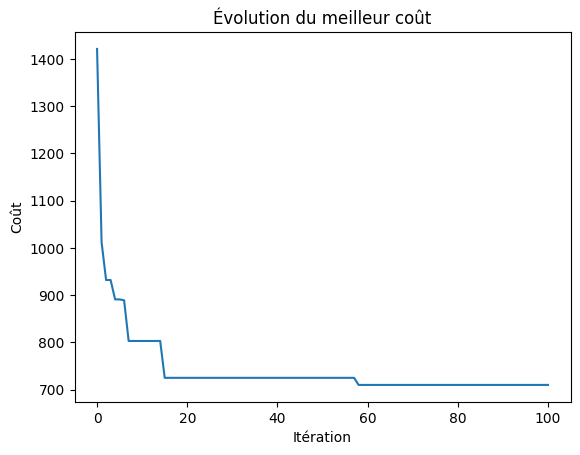


✅ Meilleur chemin trouvé :
Départ: [1, 46, 95]...[55, 69, 1]
Longueur du chemin: 101 villes
Coût total: 710


In [26]:
if __name__ == "__main__":
    try:
        file_path = "data/matrice_routes_ordre_100.csv"  # 🔁 Remplace ce chemin si nécessaire
        print(f"Chargement du fichier {file_path}...")
        matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
        
        print("\nParamètres du problème:")
        print(f"- Nombre de villes: {len(matrix)}")
        print(f"- Points de collecte: {collecte}")
        print(f"- Taille de la matrice: {matrix.shape}")
        
        # Instanciation et résolution
        solver = ACO_TSP(matrix, collecte)
        solution, cost = solver.solve(
            num_ants=50,
            iterations=100,
            alpha=1.0,
            beta=3.0,
            evaporation_rate=0.4,
            Q=100.0
        )
        
        print("\n✅ Meilleur chemin trouvé :")
        solution_int = [int(city) for city in solution]
        print(f"Départ: {solution_int[:3]}...{solution_int[-3:]}")
        print(f"Longueur du chemin: {len(solution)} villes")
        print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"❌ Erreur: {str(e)}")
